# Spam detection using Naive Bayes


## Importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading dataset

In [2]:
df = pd.read_csv('Datasets/spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Getting information about the dataset

In [8]:
df.groupby('label').describe()


message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Histogram

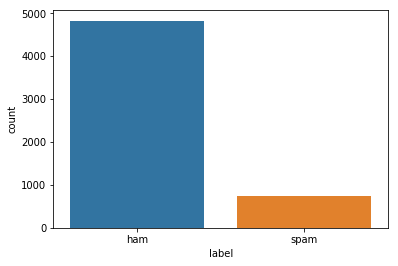

In [9]:
sns.countplot(data=df, x='label')


### Word cloud of spam 

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

spam_words=[]
spam_messages = df[df["label"] == "spam"]["message"]
def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
spam_messages=spam_messages.apply(extractSpamWords)



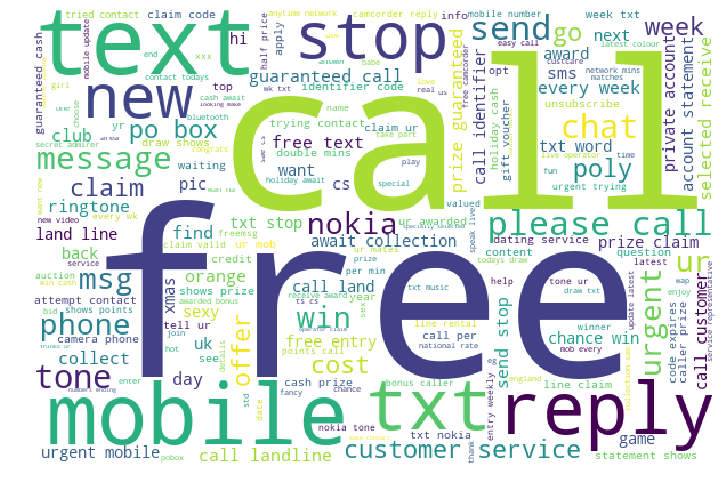

In [11]:
from wordcloud import WordCloud
spam_wordcloud = WordCloud(width=600, height=400,background_color='white').generate(" ".join(spam_words))
plt.figure( figsize=(10,8))
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Data preprocessing

<li>Remove punctuations</li>
<li>Remove stopwords</li>
<li>Stemming</li>

In [12]:
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer
def process(text):
    # lowercase it
    text = text.lower()
    # remove punctuation
    text = ''.join([t for t in text if t not in string.punctuation])
    # remove stopwords
    text = [t for t in text.split() if t not in stopwords.words('english')]
    # stemming
    st = Stemmer()
    text = [st.stem(t) for t in text]
    # return token list
    return text


## Converting the data to vectors

### Calculating TF-IDF of each message in the corpus
<br>

<li>TF(t)= Number of times term t appears in document p / Total number of terms in document p</li>
<li>Inverse Document Frequency, IDF(t)= loge(Total number of documents / Number of documents with term t in it)</li>
<li>TF-IDF(t) = TF(t)*IDF(t)</li>

We are using TfidfVectorizer which converts the message corpus into 2D matrix
<li>One dimension represents the document</li>
<li>Second dimension represents each unique word in message corpus</li>


In [13]:
df.iloc[8]['message']

'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfv = TfidfVectorizer(analyzer=process)
data = tfidfv.fit_transform(df['message'])
mess = df.iloc[8]['message']
j = tfidfv.transform([mess]).toarray()[0]



In [15]:
print('index\tidf\ttfidf\tterm')
for i in range(len(j)):
    if j[i] != 0:
        print(i, format(tfidfv.idf_[i], '.4f'), format(j[i], '.4f'), tfidfv.get_feature_names()[i],sep='\t')

index	idf	tfidf	term
218	8.5271	0.2984	09061701461
321	6.9176	0.2421	12
1755	3.2422	0.1135	call
1987	4.9252	0.3448	claim
2037	6.1917	0.2167	code
2257	5.4826	0.1919	custom
3661	5.6744	0.1986	hour
4159	8.5271	0.2984	kl341
4947	6.0993	0.2135	network
5664	5.1598	0.1806	prize
5857	8.5271	0.2984	receivea
5971	7.2278	0.2530	reward
6184	6.0148	0.2105	select
7428	6.4476	0.2257	valid
7430	6.7353	0.2357	valu
7715	6.7925	0.2377	winner
8085	7.5462	0.2641	å£900


# Training our classifier


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
spam_filter = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=process)), # messages to weighted TFIDF score
    ('classifier', MultinomialNB())                    # train on TFIDF vectors with Naive Bayes
])

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.20, random_state = 21)

In [18]:
spam_filter.fit(x_train, y_train)


Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer=<function process at 0x0000021A9E37AF78>,
        binary=False, decode_error='strict', dtype=<class 'numpy.float64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), norm='l...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [19]:
predictions = spam_filter.predict(x_test)

# Evaluating the model 

In [20]:
count = 0
for i in range(len(y_test)):
    
        if y_test.iloc[i] != predictions[i]:
            count += 1
print('Total number of test cases', len(y_test))
print('Number of wrong of predictions', count)

Total number of test cases 1115
Number of wrong of predictions 39


<class 'numpy.ndarray'>


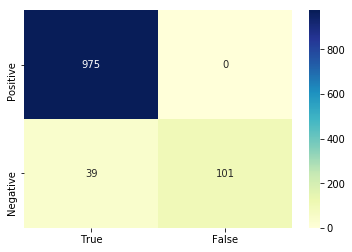

<Figure size 288x288 with 0 Axes>

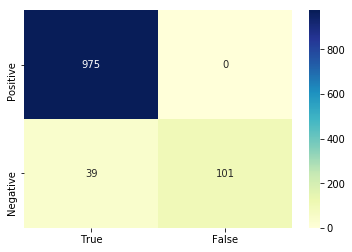

<Figure size 288x288 with 0 Axes>

In [22]:
import array
print(type(predictions))
predictions2=predictions
p3=predictions
predictions2[predictions2=='ham']=0
predictions2[predictions2=='spam']=1
p3[p3=='ham']=1
p3[predictions2=='spam']=0
predictions2 = predictions2.astype(np.int)
p3=p3.astype(np.int)
# print(predictions)
f1=y_test.to_frame()
f1['label'].replace('ham',0,inplace=True)
f1['label'].replace('spam',1,inplace=True)
f2=y_test.to_frame()
f2['label'].replace('ham',0,inplace=True)
f2['label'].replace('spam',1,inplace=True)
# f1['label'].get_dtype_counts()
# f1.head(10)
# print(predictions)

# pred_bin = pd.get_dummies(predictions)
# y_test_binary
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(f1['label'], predictions2)
df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Positive","Negative",]],
                  columns = [i for i in ["True","False"]])
sns.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt="d",cmap="YlGnBu")

plt.figure(figsize = (4,4))
plt.show()

conf_mat = confusion_matrix(f2['label'], p3)
df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Positive","Negative",]],
                  columns = [i for i in ["True","False"]])
sns.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt="d",cmap="YlGnBu")

plt.figure(figsize = (4,4))
plt.show()


In [102]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1014
        spam       0.72      1.00      0.84       101

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.97      0.97      1115



# Testing the model

In [ ]:
def detect_spam(s):
    return spam_filter.predict([s])[0]

In [ ]:
detect_spam('Your cash-balance is currently 500 pounds - to maximize your cash-in now, send COLLECT to 83600.')

In [ ]:
detect_spam("Good morning sir. The document who said to verify is verified and the report has been mailed to you. Good day sir")

In [ ]:
detect_spam("You have won a lottery of Rs. 10lacs. Collect it before 14 March 2020")